In [20]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import pandas as pd
import seq_generator
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import json


pars = json.load(open("tuner_run/best_hps.json"))

train_ds , val_ds = seq_generator.get_train_and_val(batch_size=128)
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


inputs = tf.keras.Input([260,260,3])


x = tf.keras.layers.Resizing(224,224) (inputs)

x = img_augmentation(x)

base = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_tensor= x)

base.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base.output)

cnn = tf.keras.Model(inputs,x)

def build_model(hps):


    inputs = tf.keras.Input([5,260,260,3])
    x = layers.TimeDistributed(cnn)(inputs)

    drop1 = hps["drop1"]

    x = layers.TimeDistributed( layers.Dropout(drop1), name = "drop1") (x)

    hidden_units =  hps["hidden_units"]

    if hps["rnn"] == "lstm":
        x = layers.LSTM(hidden_units, name = "lstm")(x)
    else:
        x = layers.GRU(hidden_units, name = "gru") (x)

    drop2 = hps["drop2"]
    x = layers.Dropout(drop2,name ="drop2")(x)

    outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

    learning_rate = hps["lr"]

    model = tf.keras.Model(inputs,outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_model(pars)


In [21]:
model.fit(train_ds, epochs=1, validation_data=val_ds)

283/283 [==============================] - 112s 375ms/step - loss: 0.1435 - accuracy: 0.9575 - val_loss: 0.2768 - val_accuracy: 0.8900


In [22]:
model.save_weights("tuner_run/inet_frozen.ckpt")

In [23]:
cnn.trainable = True
for layer in cnn.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

for layer in cnn.layers[:-20]:

        layer.trainable = False

cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_1 (Resizing)          (None, 224, 224, 3)  0           ['input_14[0][0]']               
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['resizing_1[0][0]']             
                                                                                                  
 rescaling_11 (Rescaling)       (None, 224, 224, 3)  0           ['img_augmentation[0][0]'] 

In [24]:
inputs = tf.keras.Input([5,260,260,3])
x = layers.TimeDistributed(cnn)(inputs)

drop1 = pars["drop1"]

x = layers.TimeDistributed( layers.Dropout(drop1), name = "drop1") (x)

hidden_units =  pars["hidden_units"]

if pars["rnn"] == "lstm":
    x = layers.LSTM(hidden_units, name = "lstm")(x)
else:
    x = layers.GRU(hidden_units, name = "gru") (x)

drop2 = pars["drop2"]
x = layers.Dropout(drop2,name ="drop2")(x)

outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

learning_rate = pars["lr"]

model = tf.keras.Model(inputs,outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [25]:
model.load_weights("tuner_run/inet_frozen.ckpt")

In [26]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 5, 260, 260, 3)]  0         
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 1280)          4049571   
 tributed)                                                       
                                                                 
 drop1 (TimeDistributed)     (None, 5, 1280)           0         
                                                                 
 lstm (LSTM)                 (None, 192)               1131264   
                                                                 
 drop2 (Dropout)             (None, 192)               0         
                                                                 
 pred (Dense)                (None, 2)                 386       
                                                           

In [27]:
callbacks = []
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    filepath=f"tuner_run/imnet_warm.ckpt",
    verbose=1,
    save_weights_only=True,
    save_best_only=True))

callbacks.append(tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    mode='auto'))

model.fit(train_ds, epochs=10, validation_data=val_ds,callbacks=callbacks)


Epoch 1/10
283/283 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9818
Epoch 1: val_accuracy improved from -inf to 0.93906, saving model to tuner_run\imnet_warm.ckpt
283/283 [==============================] - 120s 404ms/step - loss: 0.0727 - accuracy: 0.9818 - val_loss: 0.1776 - val_accuracy: 0.9391
Epoch 2/10
283/283 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9959
Epoch 2: val_accuracy improved from 0.93906 to 0.94085, saving model to tuner_run\imnet_warm.ckpt
283/283 [==============================] - 114s 401ms/step - loss: 0.0282 - accuracy: 0.9959 - val_loss: 0.1795 - val_accuracy: 0.9408
Epoch 3/10
283/283 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9969
Epoch 3: val_accuracy did not improve from 0.94085
283/283 [==============================] - 112s 397ms/step - loss: 0.0207 - accuracy: 0.9969 - val_loss: 0.2173 - val_accuracy: 0.9223
Epoch 4/10
283/283 [==============================] - ETA: 0s -

In [38]:
labels = np.argmax(np.concatenate(list(val_ds.map(lambda x,y: y))),axis = 1)

In [41]:
val_df = pd.read_feather('new_train_seqs.df').set_index('index').query('ds_type == "val"').iloc[:len(labels)]

In [44]:
(labels == (val_df.view_direction == 'Sideways')).all()

True

In [58]:
val_df['labels'] = (val_df.view_direction == 'Sideways').astype(float)

In [45]:
model.load_weights('tuner_run\imnet_warm.ckpt')
model.evaluate(val_ds)

35/35 [==============================] - 12s 342ms/step - loss: 0.1795 - accuracy: 0.9408


[0.17948035895824432, 0.9408482313156128]

In [46]:
preds = model.predict(val_ds,verbose = 1)[:,1]

35/35 [==============================] - 14s 328ms/step


In [57]:
val_df['pred'] = preds

In [59]:
bce = tf.keras.losses.BinaryCrossentropy(red)
bce(val_df.labels,val_df.pred).numpy()

0.28182873

In [65]:
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
val_df['loss'] = bce(val_df.labels.values[:,None],preds[:,None])

In [68]:
val_df.sort_values("loss").reset_index().to_feather('imgl.df')

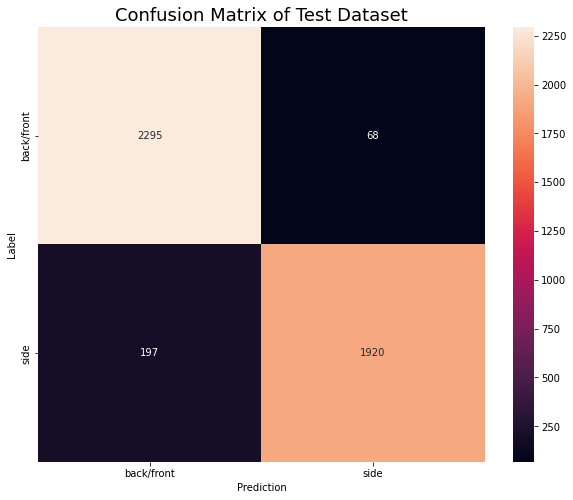

In [72]:
confusion_mtx = tf.math.confusion_matrix(labels,preds > 0.5)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

names = ["back/front","side"]

sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
plt.title("Confusion Matrix of Test Dataset",fontsize=18)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()